In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
XCr_path = os.getcwd()+'/../'
sys.path.append(XCr_path)
from XCrystal import *
from scipy.spatial.transform import Rotation as R

## Loading XCrystal configuration

In [29]:
xcr = XCrystal(XCr_path+'/config/C400_9p8keV_LaueAssymRefl15degFig2.yaml')
pp=xcr.configure(0,0)

No deformation model was selected


## Rotation function

In [30]:
def rotate_plate_xcr(xcr, plate_center, plate_size, thickness, rotation_axis, rotation_angle):
    
    x = xcr.xx
    y = xcr.yy
    z = xcr.z
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    # Stack the coordinates
    coords = np.stack((X, Y, Z), axis=-1) - plate_center

    # Create rotation matrix
    rotation = R.from_rotvec(np.deg2rad(rotation_angle) * np.array(rotation_axis))
    rotation_matrix = rotation.as_matrix()

    # Apply rotation
    rotated_coords = np.tensordot(coords, rotation_matrix, axes=([3], [1]))

    # Conditions for the plate
    length, width = plate_size
    half_thickness = thickness / 2

    cond_x = np.abs(rotated_coords[..., 0]) <= length / 2
    cond_y = np.abs(rotated_coords[..., 1]) <= width / 2
    cond_z = np.abs(rotated_coords[..., 2]) <= half_thickness

    plate_mask = cond_x & cond_y & cond_z

    return plate_mask

## Create boolean mask for where the crystal is

In [43]:
XCrArray = np.zeros((np.shape(xcr.xx)[0], np.shape(xcr.yy)[0], np.shape(xcr.z)[0]))
mask1 = rotate_plate_xcr(xcr, (xcr.xs, 0, 0), (2 * xcr.HH, xcr.width * 1e-6 * xcr.convr), xcr.CrSize, (0, 1, 0), -np.rad2deg(xcr.asymm_angle))

In [44]:
XCrArray[mask1]=True

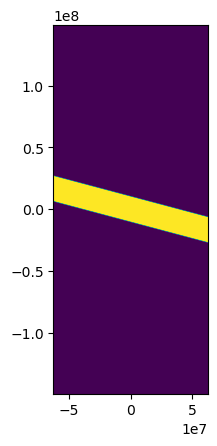

In [46]:
plt.imshow(XCrArray[:,0,:], extent=[min(xcr.z), max(xcr.z), min(xcr.xx), max(xcr.xx)], aspect='equal')

## Save the mask in the geometry file

In [7]:
np.save('Asymm.geom',mask1) 